<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [4]:
!pip install --upgrade --no-cache-dir gdown --quiet

You should consider upgrading via the 'd:\facultad\especialización\4. cuarto bimestre\nlp\env\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\NLP\Tps\clothing_ecommerce_reviews.csv
100%|██████████████████████████████████████████████████| 8.48M/8.48M [00:00<00:00, 9.19MB/s]


In [2]:
# Armar el dataset
df = pd.read_csv('./Data/clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [3]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [4]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

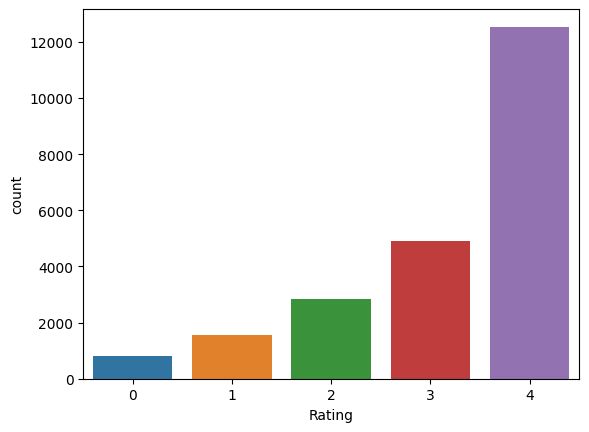

In [5]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()

El dataset está muy desbalanceado. Haré un undersampling para ver como funciona el modelo con ese dataset.

In [29]:
Rating_0 = df_reviews[df_reviews['Rating']==0]
Rating_1 = df_reviews[df_reviews['Rating']==1]
Rating_2 = df_reviews[df_reviews['Rating']==2]
Rating_3 = df_reviews[df_reviews['Rating']==3]
Rating_4 = df_reviews[df_reviews['Rating']==4]
Rating_1 = Rating_1.sample(n=len(Rating_0), random_state=101)
Rating_2 = Rating_2.sample(n=len(Rating_0), random_state=101)
Rating_3 = Rating_3.sample(n=len(Rating_0), random_state=101)
Rating_4 = Rating_4.sample(n=len(Rating_0), random_state=101)
df_under = pd.concat([Rating_0, Rating_1, Rating_2, Rating_3, Rating_4],axis=0)

In [30]:
df_under['Rating'].value_counts()

0    821
1    821
2    821
3    821
4    821
Name: Rating, dtype: int64

In [31]:
df_under.head()

,Review Text,Rating
61,"3 tags sewn in, 2 small (about 1'' long) and 1...",0
85,"I was really hoping to like this, but it did n...",0
96,I usually wear a medium and bought a small. it...,0
97,I was very excited to order this top in red xs...,0
110,This is so thin and poor quality. especially f...,0


In [32]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_under['Review Text'].values
text_sequences.shape

(4105,)

In [33]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

4105

In [34]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)


In [35]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

1294453

In [36]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [37]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['3',
 'tags',
 'sewn',
 'in',
 '2',
 'small',
 'about',
 "1''",
 'long',
 'and',
 '1',
 'huge',
 'about',
 "2''",
 'x',
 "3''",
 'very',
 'itchy',
 'so',
 'i']

In [38]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

253004

In [39]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 4000
vocab_size = num_words
tok = Tokenizer(num_words=4000) 
tok.fit_on_texts(tokens)

In [40]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

7207

In [41]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [42]:
sequences[0][:10]

[344, 2161, 642, 9, 150, 41, 110, 102, 3, 465]

In [43]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

112

In [44]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.utils import pad_sequences
maxlen = 112
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [45]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(4105, 112)

In [46]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_under['Rating'].values
print(y.shape)

(4105,)


In [47]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [63]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape =5
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 112 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [67]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout


model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=20, input_length=in_shape))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 20)           80020     
                                                                 
 lstm_1 (LSTM)               (None, 115, 32)           6784      
                                                                 
 dropout (Dropout)           (None, 115, 32)           0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [78]:
hist = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
83/83 [==============================] - 7s 53ms/step - loss: 1.5830 - accuracy: 0.2398 - val_loss: 1.4522 - val_accuracy: 0.3455
Epoch 2/10
83/83 [==============================] - 4s 46ms/step - loss: 1.3160 - accuracy: 0.3677 - val_loss: 1.2891 - val_accuracy: 0.3668
Epoch 3/10
83/83 [==============================] - 4s 46ms/step - loss: 1.1904 - accuracy: 0.4164 - val_loss: 1.3027 - val_accuracy: 0.3851
Epoch 4/10
83/83 [==============================] - 4s 46ms/step - loss: 1.0851 - accuracy: 0.4663 - val_loss: 1.3743 - val_accuracy: 0.3866
Epoch 5/10
83/83 [==============================] - 4s 46ms/step - loss: 1.0290 - accuracy: 0.5166 - val_loss: 1.4545 - val_accuracy: 0.3973
Epoch 6/10
83/83 [==============================] - 4s 46ms/step - loss: 0.9596 - accuracy: 0.5603 - val_loss: 1.5617 - val_accuracy: 0.3881
Epoch 7/10
83/83 [==============================] - 4s 46ms/step - loss: 0.8661 - accuracy: 0.6171 - val_loss: 1.6180 - val_accuracy: 0.3942
Epoch 8/10
83

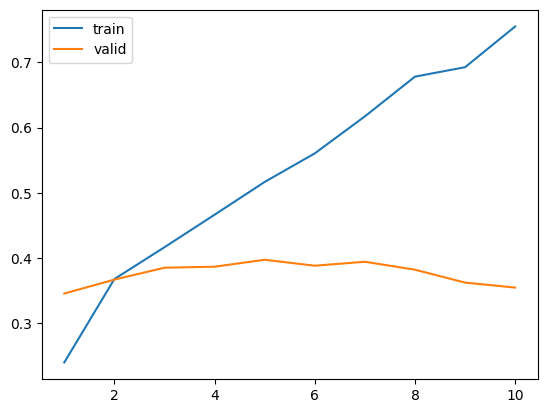

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [80]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 14ms/step - loss: 2.1472 - accuracy: 0.3739


[2.1472268104553223, 0.37393423914909363]

Conclusión: Al haber reducido la cantidad de datos por el undersampling para nivelar las clases, vemos que el modelo tiende al overfitting además porque está entrenando sus propios embeddings. Veamos cómo le va con embeddings entrenados. 

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [83]:
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\NLP\Tps\fasttext.pkl
100%|██████████████████████████████████████████████████| 2.88G/2.88G [02:22<00:00, 20.3MB/s]


In [10]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = './embeddings/fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [11]:
model_fasttext = FasttextEmbeddings()

In [64]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim =300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', len(words_not_found))

preparing embedding matrix...
number of null word embeddings: 0


In [65]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

Defino el modelo con los mismo parámetros del anterior para poder hacer la comparación. 

In [108]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=32, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(units=16)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(rate=0.3))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 112, 300)          1200000   
                                                                 
 lstm_14 (LSTM)              (None, 112, 32)           42624     
                                                                 
 dropout_14 (Dropout)        (None, 112, 32)           0         
                                                                 
 lstm_15 (LSTM)              (None, 16)                3136      
                                                                 
 dense_14 (Dense)            (None, 64)                1088      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 5)                

In [109]:
hist2 = model2.fit(X_train, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
83/83 [==============================] - 12s 75ms/step - loss: 1.6104 - accuracy: 0.2120 - val_loss: 1.6162 - val_accuracy: 0.1750
Epoch 2/15
83/83 [==============================] - 5s 59ms/step - loss: 1.6108 - accuracy: 0.2037 - val_loss: 1.6039 - val_accuracy: 0.2314
Epoch 3/15
83/83 [==============================] - 5s 58ms/step - loss: 1.6009 - accuracy: 0.2349 - val_loss: 1.6056 - val_accuracy: 0.2268
Epoch 4/15
83/83 [==============================] - 5s 61ms/step - loss: 1.5951 - accuracy: 0.2246 - val_loss: 1.6015 - val_accuracy: 0.2253
Epoch 5/15
83/83 [==============================] - 5s 58ms/step - loss: 1.5854 - accuracy: 0.2478 - val_loss: 1.5919 - val_accuracy: 0.2283
Epoch 6/15
83/83 [==============================] - 5s 58ms/step - loss: 1.5752 - accuracy: 0.2608 - val_loss: 1.5756 - val_accuracy: 0.2405
Epoch 7/15
83/83 [==============================] - 5s 58ms/step - loss: 1.5646 - accuracy: 0.2585 - val_loss: 1.5956 - val_accuracy: 0.2314
Epoch 8/15
8

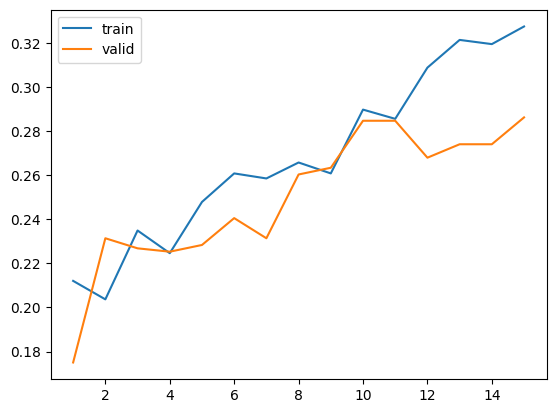

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

Conclusión: Con los embeddings entrenados mejora mucho la reducción de overfitting, sin embargo, la performance del modelo es baja. 

## Prueba con undersampling a la cantidad de muestras de la clase 2

Voy a probar hacer un undersampling menos agresivo para tener un poco más de datos disponibles y ver si se puede mejorar la performance.

In [112]:
Rating_0 = df_reviews[df_reviews['Rating']==0]
Rating_1 = df_reviews[df_reviews['Rating']==1]
Rating_2 = df_reviews[df_reviews['Rating']==2]
Rating_3 = df_reviews[df_reviews['Rating']==3]
Rating_4 = df_reviews[df_reviews['Rating']==4]
Rating_3 = Rating_3.sample(n=len(Rating_2), random_state=101)
Rating_4 = Rating_4.sample(n=len(Rating_2), random_state=101)
df_under_2 = pd.concat([Rating_0, Rating_1, Rating_2, Rating_3, Rating_4],axis=0)

In [113]:
df_under_2['Rating'].value_counts()

2    2823
3    2823
4    2823
1    1549
0     821
Name: Rating, dtype: int64

In [120]:
text_sequences_2 = df_under_2['Review Text'].values
text_sequences_2.shape

(10839,)

In [122]:
corpus_2 = ' '.join(text_sequences_2)

In [123]:
len(corpus_2)

3428145

In [124]:
tokens_2 = text_to_word_sequence(corpus_2)

In [125]:
tokens_2[:20]

['3',
 'tags',
 'sewn',
 'in',
 '2',
 'small',
 'about',
 "1''",
 'long',
 'and',
 '1',
 'huge',
 'about',
 "2''",
 'x',
 "3''",
 'very',
 'itchy',
 'so',
 'i']

In [126]:
len(tokens_2)

671955

In [127]:
num_words = 4000
vocab_size = num_words
tok = Tokenizer(num_words=4000) 
tok.fit_on_texts(tokens_2)

In [128]:
word_index_2 = tok.word_index
len(word_index_2)

10914

In [129]:
sequences_2 = tok.texts_to_sequences(text_sequences_2)

In [130]:
sequences_2[0][:10]

[358, 2290, 694, 9, 163, 42, 120, 87, 3, 466]

In [132]:
max(len(s) for s in sequences_2)

115

In [133]:
maxlen = 115
X_2 = pad_sequences(sequences_2, padding='pre', maxlen=maxlen)

In [134]:
X_2.shape

(10839, 115)

In [136]:
y_2 = df_under_2['Rating'].values
print(y.shape)

(10839,)


In [137]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=1)

In [142]:
in_shape = X_train_2.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


Vamos a entrenar la LSTM directamente con los embeddings pre-entrenados

In [169]:
model3 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model3.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model3.add(LSTM(units=8, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=8)) # La última capa LSTM no lleva return_sequences

model3.add(Dense(units=16, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=out_shape, activation='softmax'))

model3.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 115, 300)          1200000   
                                                                 
 lstm_32 (LSTM)              (None, 115, 8)            9888      
                                                                 
 dropout_32 (Dropout)        (None, 115, 8)            0         
                                                                 
 lstm_33 (LSTM)              (None, 8)                 544       
                                                                 
 dense_32 (Dense)            (None, 16)                144       
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 5)               

In [172]:
hist3 = model3.fit(X_train_2, y_train_2, epochs=30, validation_split=0.2)

Epoch 1/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4574 - accuracy: 0.3483 - val_loss: 1.4646 - val_accuracy: 0.3424
Epoch 2/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4539 - accuracy: 0.3535 - val_loss: 1.4609 - val_accuracy: 0.3573
Epoch 3/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4514 - accuracy: 0.3567 - val_loss: 1.4598 - val_accuracy: 0.3470
Epoch 4/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4471 - accuracy: 0.3612 - val_loss: 1.4580 - val_accuracy: 0.3441
Epoch 5/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4434 - accuracy: 0.3558 - val_loss: 1.4556 - val_accuracy: 0.3556
Epoch 6/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4444 - accuracy: 0.3622 - val_loss: 1.4584 - val_accuracy: 0.3550
Epoch 7/30
217/217 [==============================] - 10s 47ms/step - loss: 1.4369 - accuracy: 0.3658 - val_loss: 1.4569 - val_accuracy:

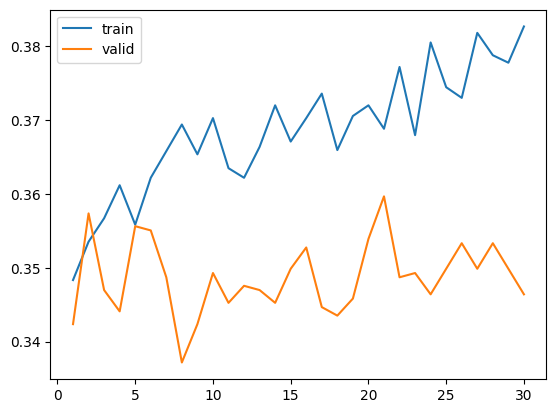

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='valid')
plt.show()

In [174]:
model3.evaluate(X_test_2, y_test_2)

68/68 [==============================] - 1s 13ms/step - loss: 1.4522 - accuracy: 0.3450


[1.4521921873092651, 0.3450184464454651]

## Prueba con reducción de clases

Haré una prueba con reducción de clases: pasar de 5 clases a 3. 

In [102]:
Rating_0 = df_reviews[df_reviews['Rating']==0]
Rating_1 = df_reviews[df_reviews['Rating']==0]
Rating_2 = df_reviews[df_reviews['Rating']==0]
Rating_3 = df_reviews[df_reviews['Rating']==1]
Rating_4 = df_reviews[df_reviews['Rating']==2]
df_under_3 = pd.concat([Rating_0, Rating_1, Rating_2, Rating_3, Rating_4],axis=0)

In [103]:
df_under_3['Rating'].value_counts()

2    2823
0    2463
1    1549
Name: Rating, dtype: int64

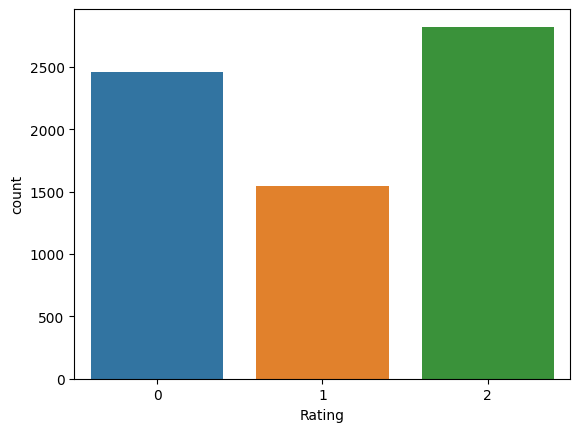

In [104]:
sns.countplot(x=df_under_3['Rating'], data=df_reviews)
plt.show()

In [105]:
text_sequences_3 = df_under_3['Review Text'].values
text_sequences_3.shape

(6835,)

In [106]:
corpus_3 = ' '.join(text_sequences_3)

In [107]:
len(corpus_3)

2173775

In [108]:
tokens_3 = text_to_word_sequence(corpus_3)

In [109]:
tokens_3[:20]

['3',
 'tags',
 'sewn',
 'in',
 '2',
 'small',
 'about',
 "1''",
 'long',
 'and',
 '1',
 'huge',
 'about',
 "2''",
 'x',
 "3''",
 'very',
 'itchy',
 'so',
 'i']

In [110]:
len(tokens_3)

424523

In [111]:
num_words = 4000
vocab_size = num_words
tok = Tokenizer(num_words=4000) 
tok.fit_on_texts(tokens_3)

In [112]:
word_index_3 = tok.word_index
len(word_index_3)

7922

In [113]:
sequences_3 = tok.texts_to_sequences(text_sequences_3)

In [114]:
sequences_3[0][:10]

[350, 1401, 517, 10, 172, 39, 116, 3501, 117, 4]

In [115]:
max(len(s) for s in sequences_3)

116

In [116]:
maxlen = 116
X_3 = pad_sequences(sequences_3, padding='pre', maxlen=maxlen)

In [117]:
X_3.shape

(6835, 116)

In [118]:
y_3 = df_under_3['Rating'].values
print(y_3.shape)

(6835,)


In [119]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=1)

In [120]:
in_shape = X_train_3.shape[1] # max input sentence len
out_shape = 3 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 116 , out_shape 3


In [121]:
model3 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model3.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model3.add(LSTM(units=64, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=out_shape, activation='softmax'))

model3.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 116, 300)          1200000   
                                                                 
 lstm_9 (LSTM)               (None, 116, 64)           93440     
                                                                 
 dropout_8 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                

In [122]:
hist4 = model3.fit(X_train_3, y_train_3, epochs=10, validation_split=0.2)

Epoch 1/10
137/137 [==============================] - 19s 107ms/step - loss: 1.0775 - accuracy: 0.3916 - val_loss: 1.0779 - val_accuracy: 0.3537
Epoch 2/10
137/137 [==============================] - 11s 77ms/step - loss: 1.0707 - accuracy: 0.4086 - val_loss: 1.0660 - val_accuracy: 0.4333
Epoch 3/10
137/137 [==============================] - 10s 72ms/step - loss: 1.0672 - accuracy: 0.4239 - val_loss: 1.0642 - val_accuracy: 0.4406
Epoch 4/10
137/137 [==============================] - 10s 72ms/step - loss: 1.0622 - accuracy: 0.4323 - val_loss: 1.0586 - val_accuracy: 0.4214
Epoch 5/10
137/137 [==============================] - 10s 75ms/step - loss: 1.0553 - accuracy: 0.4458 - val_loss: 1.0486 - val_accuracy: 0.4634
Epoch 6/10
137/137 [==============================] - 11s 77ms/step - loss: 1.0467 - accuracy: 0.4579 - val_loss: 1.0462 - val_accuracy: 0.4634
Epoch 7/10
137/137 [==============================] - 10s 71ms/step - loss: 1.0401 - accuracy: 0.4758 - val_loss: 1.0486 - val_accuracy

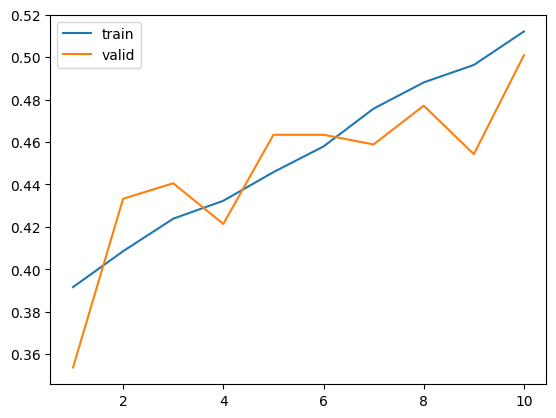

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist4.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist4.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist4.history['val_accuracy'], label='valid')
plt.show()

El mejor resultado lo obtuvimos reduciendo las clases a 3, sin embargo sigue siendo un resultado bajo. 